In [3]:
!pip -q install xgboost

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

In [5]:
csv_path = "forest_dataset.csv"
assert os.path.exists(csv_path), f"File not found at {csv_path}. Upload forest_dataset.csv to Colab (left sidebar > Files)."

df = pd.read_csv(csv_path)

In [12]:
target_col = "Cover_Type" if "Cover_Type" in df.columns else df.columns[-1]
X = df.drop(columns=[target_col])
y = df[target_col]

from sklearn.preprocessing import LabelEncoder

# Encode labels so they start at 0
le = LabelEncoder()
y = le.fit_transform(y)

# Then split again
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42)

In [13]:
# Preprocessing
categorical_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype) == "category"]
numeric_cols     = [c for c in X.columns if c not in categorical_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ],
    remainder="drop"
)

In [14]:
# models
rf = RandomForestClassifier(n_estimators=300, max_depth=None, n_jobs=-1, random_state=42)
xgb = XGBClassifier(n_estimators=400, max_depth=8, learning_rate=0.1, subsample=0.8,colsample_bytree=0.8, objective="multi:softprob", eval_metric="mlogloss",tree_method="hist", random_state=42)

rf_pipe  = Pipeline([("prep", preprocess), ("model", rf)])
xgb_pipe = Pipeline([("prep", preprocess), ("model", xgb)])



In [15]:
# Train & evaluate baseline models
def evaluate(pipe, name):
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1m = f1_score(y_test, preds, average="macro")
    print(f"{name} — Accuracy: {acc:.4f} | Macro-F1: {f1m:.4f}")
    return {"name": name, "pipe": pipe, "acc": acc, "f1m": f1m}

print("Baseline Models")
results = []
results.append(evaluate(rf_pipe,  "RandomForest (baseline)"))
results.append(evaluate(xgb_pipe, "XGBoost (baseline)"))


Baseline Models
RandomForest (baseline) — Accuracy: 0.7960 | Macro-F1: 0.6697
XGBoost (baseline) — Accuracy: 0.8040 | Macro-F1: 0.7073


In [20]:
# RandomForest small grid
rf_grid = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 20],
}

rf_tuned = GridSearchCV(
    Pipeline([("prep", preprocess), ("model", RandomForestClassifier(random_state=42, n_jobs=-1))]),
    rf_grid, cv=3, n_jobs=-1, scoring="accuracy", verbose=0
)
rf_tuned.fit(X_train, y_train)
rf_best = rf_tuned.best_estimator_
rf_preds = rf_best.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds)
rf_f1m = f1_score(y_test, rf_preds, average="macro")
print(f"RandomForest (tuned) — Best Params: {rf_tuned.best_params_}")
print(f"RandomForest (tuned) — Accuracy: {rf_acc:.4f} | Macro-F1: {rf_f1m:.4f}")
results.append({"name": "RandomForest (tuned)", "pipe": rf_best, "acc": rf_acc, "f1m": rf_f1m})

# XGBoost small grid
xgb_grid = {
    "model__n_estimators": [300, 500],
    "model__max_depth": [6, 10],
}

xgb_tuned = GridSearchCV(
    Pipeline([("prep", preprocess), ("model", XGBClassifier(
        objective="multi:softprob", eval_metric="mlogloss",
        tree_method="hist", random_state=42
    ))]),
    xgb_grid, cv=3, n_jobs=-1, scoring="accuracy", verbose=0
)
xgb_tuned.fit(X_train, y_train)
xgb_best = xgb_tuned.best_estimator_
xgb_preds = xgb_best.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_preds)
xgb_f1m = f1_score(y_test, xgb_preds, average="macro")
print(f"XGBoost (tuned) — Best Params: {xgb_tuned.best_params_}")
print(f"XGBoost (tuned) — Accuracy: {xgb_acc:.4f} | Macro-F1: {xgb_f1m:.4f}")
results.append({"name": "XGBoost (tuned)", "pipe": xgb_best, "acc": xgb_acc, "f1m": xgb_f1m})


RandomForest (tuned) — Best Params: {'model__max_depth': None, 'model__n_estimators': 400}
RandomForest (tuned) — Accuracy: 0.7960 | Macro-F1: 0.6831
XGBoost (tuned) — Best Params: {'model__max_depth': 10, 'model__n_estimators': 500}
XGBoost (tuned) — Accuracy: 0.8140 | Macro-F1: 0.7170


In [21]:
res_df = pd.DataFrame(results).drop(columns=["pipe"])
display(res_df.sort_values(by="acc", ascending=False).reset_index(drop=True))

,name,acc,f1m
0,XGBoost (tuned),0.814,0.716983
1,XGBoost (baseline),0.804,0.707318
2,RandomForest (baseline),0.796,0.669682
3,RandomForest (tuned),0.796,0.668842
4,RandomForest (tuned),0.796,0.668842
5,RandomForest (tuned),0.796,0.683117


In [22]:
best = sorted(results, key=lambda r: (r["acc"], r["f1m"]), reverse=True)[0]
best_name = best["name"]
best_pipe = best["pipe"]
print(f"\nBest model selected: {best_name}")


Best model selected: XGBoost (tuned)


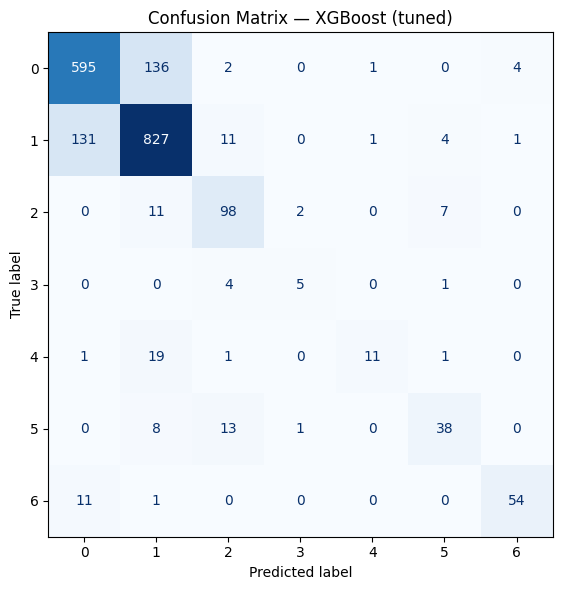

In [23]:
y_pred_best = best_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
fig = plt.figure(figsize=(7, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(values_format='d', cmap="Blues", ax=plt.gca(), colorbar=False)
plt.title(f"Confusion Matrix — {best_name}")
plt.tight_layout()
plt.show()

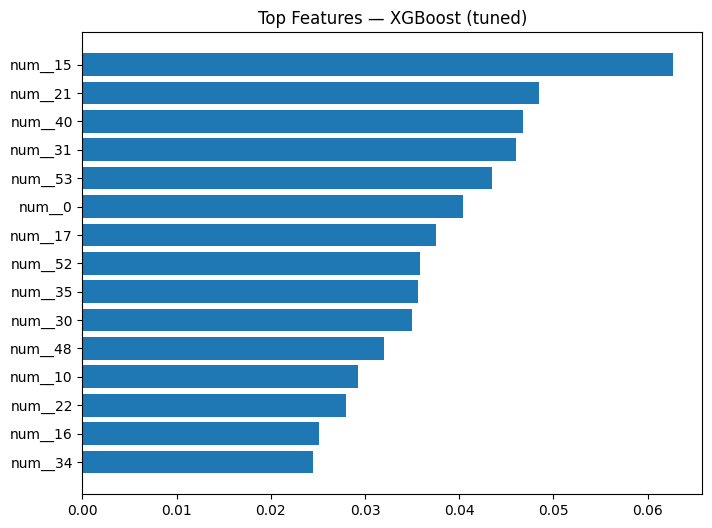

In [33]:
import pandas as pd

def get_feature_names_from_preprocessor(prep, X_sample):
    """Return correct feature names after preprocessing"""
    transformed = prep.transform(X_sample[:1])
    if hasattr(transformed, "toarray"):  # in case it's sparse
        transformed = transformed.toarray()
    return prep.get_feature_names_out()

# Use the fitted preprocessor inside best_pipe
prep = best_pipe.named_steps["prep"]
model = best_pipe.named_steps["model"]

# Extract names
feature_names = get_feature_names_from_preprocessor(prep, X_train)
import matplotlib.pyplot as plt
import numpy as np

if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
    idx = np.argsort(importances)[::-1][:15]  # top 15
    plt.figure(figsize=(8,6))
    plt.barh(np.array(feature_names)[idx], importances[idx])
    plt.gca().invert_yaxis()
    plt.title(f"Top Features — {best_name}")
    plt.show()

In [34]:
#  Final report for the selected best model
print("Final Report (Best Model on Test Set) ")
print(classification_report(y_test, y_pred_best))
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Macro-F1: {f1_score(y_test, y_pred_best, average='macro'):.4f}")

Final Report (Best Model on Test Set) 
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       738
           1       0.83      0.85      0.84       975
           2       0.76      0.83      0.79       118
           3       0.62      0.50      0.56        10
           4       0.85      0.33      0.48        33
           5       0.75      0.63      0.68        60
           6       0.92      0.82      0.86        66

    accuracy                           0.81      2000
   macro avg       0.79      0.68      0.72      2000
weighted avg       0.81      0.81      0.81      2000

Accuracy: 0.8140
Macro-F1: 0.7170
